This notebook explores the data to gain understanding of the Stack Overflow Survey 2025. 

In [ ]:
import re
from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# 1. Load Data

In [2]:
# Convert column ID to option text in the survey
file_path = Path("../data/survey_results_schema.csv")
df = pd.read_csv(file_path)
schema = pd.Series(df["sub"].values,index=df["qname"]).dropna().to_dict()

In [3]:
file_path = Path("../data/survey_results_public.csv")
df = pd.read_csv(file_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49123 entries, 0 to 49122
Columns: 170 entries, ResponseId to JobSat
dtypes: float64(50), int64(1), object(119)
memory usage: 63.7+ MB


# 2. Tool definitions

In [4]:
def convert_to_title(text: str) -> str:
    """ Convert camel case to sentence """
    return re.sub(r'(?<!^)(?=[A-Z])', ' ', text)


def plot_single_selection(df: pd.DataFrame, column: str, title: str | None = None) -> None:
    """ Plots a horizontal histogram of the number of times each option was selected """
    sns.countplot(df, y=column , order = df[column].value_counts().index, stat="percent")
    plt.ylabel("")
    plt.title(title if title is not None else convert_to_title(column))
    plt.show()


def plot_multiple_selection(df: pd.DataFrame,
                            column: str,
                            title: str | None = None,
                            max_items: int | None=None,
                            ax=None,
                            ) -> None:
    """ plots a horizontal histogram of the number of times one of the options was selected """    
    df2 = df[column].str.split(';').explode().reset_index()
    max_items = max_items if max_items is not None else len(df[column].unique())
    do_show = False
    if ax is None:
        _, ax = plt.subplots(1, 1)
        do_show = True
    sns.countplot(df2, y=column, order = df2[column].value_counts().iloc[:max_items].index, stat="percent", ax=ax)
    ax.set_ylabel("")
    ax.set_title(title if title is not None else convert_to_title(column))
    if do_show:
        plt.show()


def plot_multiple_selection_combi(df: pd.DataFrame, column: str, title: str | None = None, max_items: int | None=None) -> None:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
    plot_multiple_selection(df, column=column + "HaveWorkedWith", title=None, max_items=max_items, ax = ax1)
    plot_multiple_selection(df, column=column + "WantToWorkWith", title=None, max_items=max_items, ax = ax2)
    plot_multiple_selection(df, column=column + "Admired", title=None, max_items=max_items, ax = ax3)
    plt.tight_layout()


def plot_numerical_field(df: pd.DataFrame, column: str, title: str | None = None, bins : int | np.ndarray = 20) -> None:
    sns.histplot(df, x=column, bins=bins, stat="percent")
    plt.title(title if title is not None else convert_to_title(column))
    plt.show()


def plot_ranking(df: pd.DataFrame, column_prefix: str, title: str | None = None, schema: dict=schema) -> None:
    # Select columns and untangle
    melted_df = (df
                 .filter(regex=rf"^{column_prefix}_(?!.*_TEXT$)", axis=1)
                 .rename(columns=schema)
                 .dropna(how='all')
                 .melt(var_name='Option', value_name='Rank')
                 )
    melted_df["Rank"] = melted_df["Rank"].astype(int)

    # Count occurrences of each rank per option
    rank_counts = melted_df.groupby(['Option', 'Rank']).size().reset_index(name='Count')

    # Pivot the table to create a matrix format
    matrix_df = rank_counts.pivot(index='Option', columns='Rank', values='Count').fillna(0)
    matrix_df = matrix_df.loc[~matrix_df.index.str.startswith("Other")] # remove "Other" option
    matrix_df = matrix_df.div(matrix_df.sum(axis=1), axis=0) * 100
    
    # sort    
    total_points = np.sum(matrix_df.to_numpy() * np.arange(matrix_df.shape[1], 0, -1)[None, :], axis=1)
    matrix_df = matrix_df.iloc[np.argsort(total_points)[::-1]]

    # Create plot
    plt.figure(figsize=(10, 6))    
    sns.heatmap(matrix_df, annot=True, cmap='viridis', cbar_kws={'label': '%'})
    plt.title(title if title is not None else convert_to_title(column_prefix))
    plt.show()


def plot_co_occurance(df: pd.DataFrame, column: str, n_top: int = 15, max_responses: int=5):

    # Drop NaN values and filter rows with <= m selections
    filtered = df[column].dropna().apply(lambda x: x.split(';'))
    filtered = filtered[filtered.apply(len) <= max_responses]

    # Flatten and count all selections    
    most_common = filtered.explode().value_counts().head(n_top).index.tolist()

    # Initialize co-occurrence matrix
    matrix_df = pd.DataFrame(0.0, index=most_common, columns=most_common)

    # Populate the matrix
    for selection in filtered:
        selected = [item for item in selection if item in most_common]
        if len(selected) == 1:
            matrix_df.loc[selected[0], selected[0]] += 1
        else:
            for a, b in combinations(selected, 2):
                matrix_df.loc[a, b] += 1.0 / len(selected)
                matrix_df.loc[b, a] += 1.0 / len(selected)

    matrix_df = matrix_df.div(matrix_df.sum(axis=1), axis=0) * 100

    # Plot the matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_df, annot=True, fmt='.1f', cmap='Blues')    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()    


def plot_have_and_want(df: pd.DataFrame, column_have: str, column_want:str, n_top: int = 15, max_responses: int=5):

    # Drop NaN values and filter rows with <= m selections
    have_filtered = df[column_have].dropna().apply(lambda x: x.split(';'))
    have_filtered = have_filtered[have_filtered.apply(len) <= max_responses]

    want_filtered = df[column_want].dropna().apply(lambda x: x.split(';'))
    want_filtered = want_filtered[want_filtered.apply(len) <= max_responses]

    # Flatten and count all selections    
    most_common = have_filtered.explode().value_counts().head(n_top).index.tolist()

    # Initialize co-occurrence matrix
    matrix_df = pd.DataFrame(0.0, index=most_common, columns=most_common)

    # Populate the matrix
    for have_selection, want_selection in zip(have_filtered, want_filtered):
        selected = [item for item in have_selection if item in most_common]
        for h in selected:
            for w in [item for item in want_selection if item in most_common]:
                matrix_df.loc[h, w] += 1.0 / len(selected)
       
    matrix_df = matrix_df.div(matrix_df.sum(axis=1), axis=0) * 100

    # Plot the matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_df, annot=True, fmt='.1f', cmap='Blues')    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()    


def plot_have_and_want2(df: pd.DataFrame, column_have: str, column_want:str, n_top: int = 15, max_responses: int=5):

    # Drop rows with NaN in either column
    df2 = df.dropna(subset=[column_have, column_want])

    # Split selections into lists
    df2["Have"] = df2[column_have].str.split(";")
    df2["Want"] = df2[column_want].str.split(";")

    # Filter rows with <= m_max selections in HaveWorkedWith
    df2 = df2[df2["Have"].apply(len) <= max_responses]

    # Flatten all selections to get top n languages
    all_languages = pd.Series([lang for sublist in df2["Have"] for lang in sublist])
    top_languages = all_languages.value_counts().head(n_top).index.tolist()

    # Initialize matrix
    matrix_df = pd.DataFrame(0.0, index=top_languages, columns=top_languages)

    # Populate matrix
    for _, row in df2.iterrows():
        worked = [lang for lang in row["Have"] if lang in top_languages]
        want = [lang for lang in row["Want"] if lang in top_languages]
        for w in worked:
            for v in want:
                matrix_df.loc[w, v] += 1.0
                
    matrix_df = matrix_df.div(matrix_df.sum(axis=1), axis=0) * 100
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_df, annot=True, fmt='.2f', cmap='YlGnBu')
    plt.title("Languages Worked With vs. Languages Wanted To Work With")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()


# 3. Explore data

## Personal

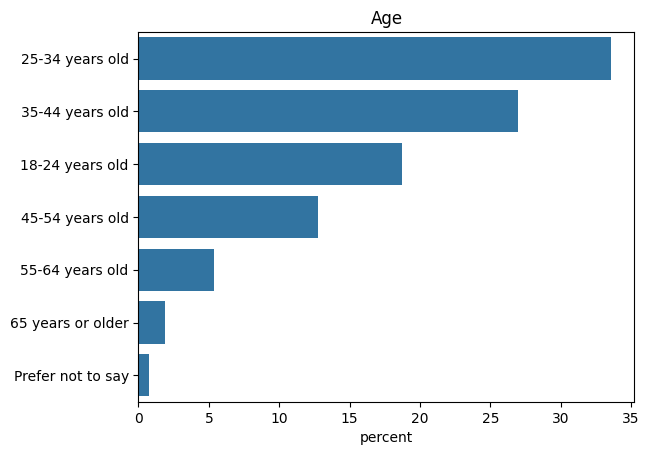

In [5]:
plot_single_selection(df, "Age")

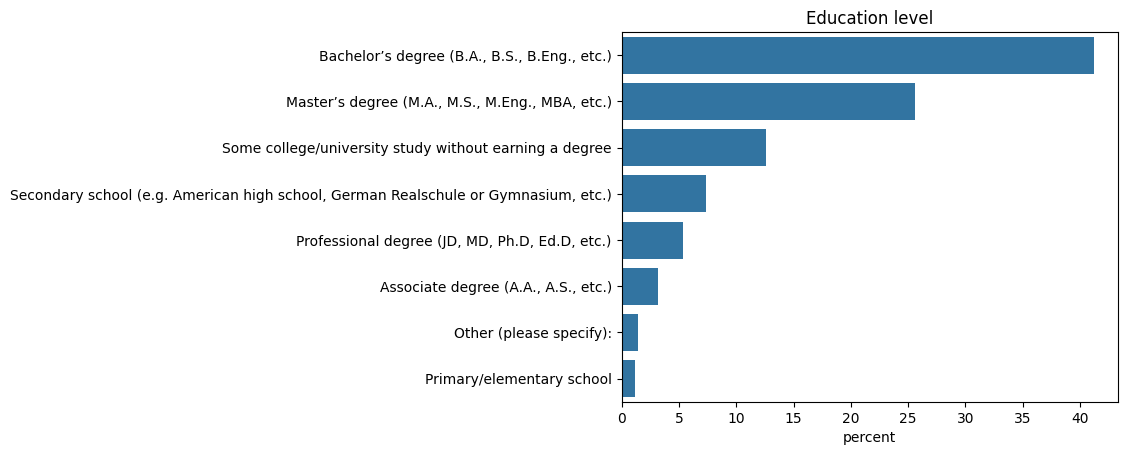

In [6]:
plot_single_selection(df, "EdLevel", "Education level")

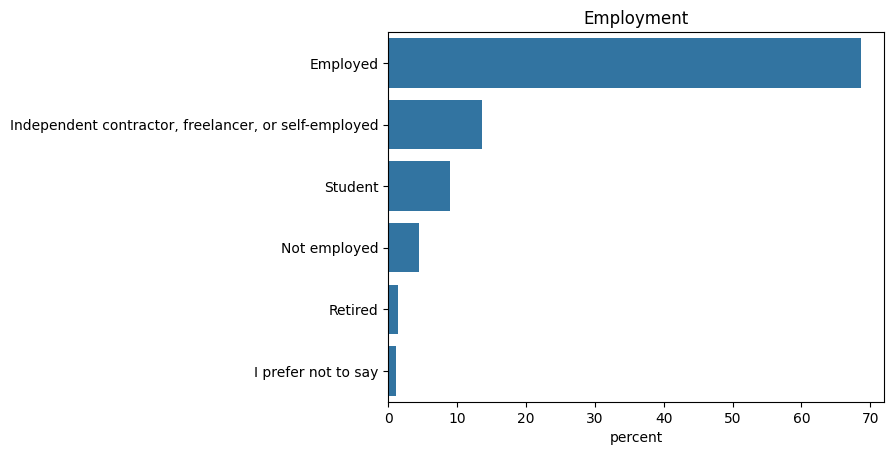

In [7]:
plot_single_selection(df, "Employment")

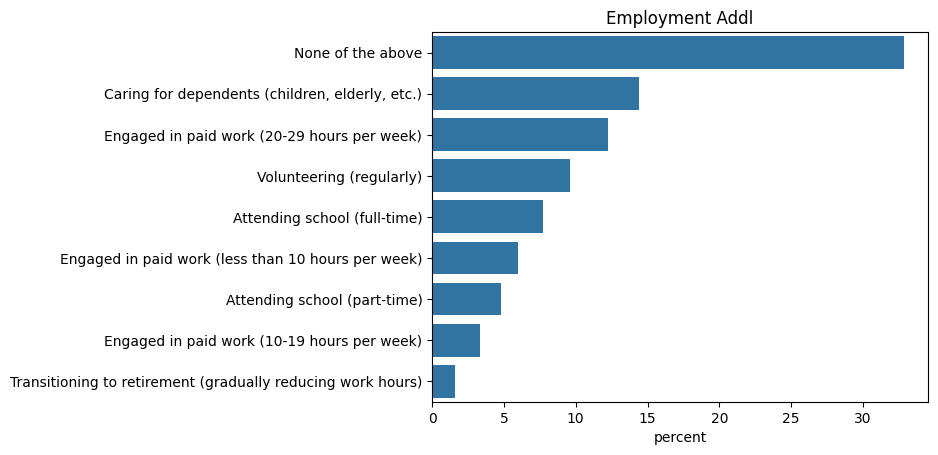

In [8]:
plot_multiple_selection(df, "EmploymentAddl")

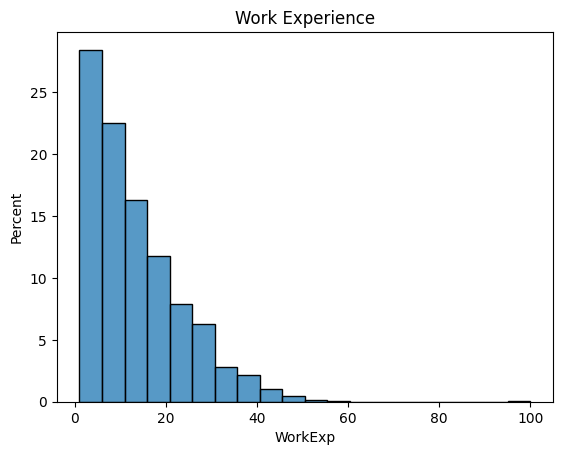

In [9]:
plot_numerical_field(df, "WorkExp", "Work Experience")

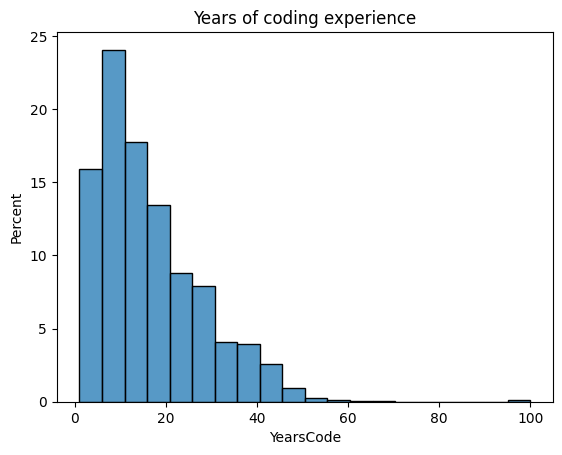

In [10]:
plot_numerical_field(df, "YearsCode", "Years of coding experience")

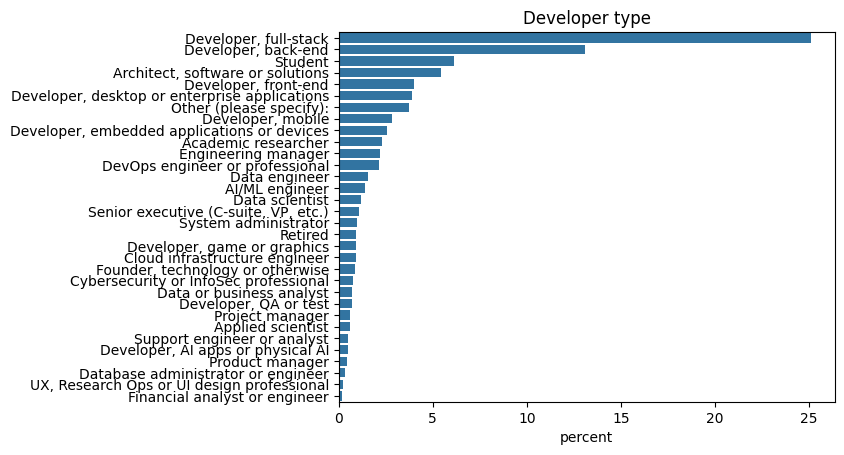

In [11]:
plot_single_selection(df, "DevType", "Developer type")

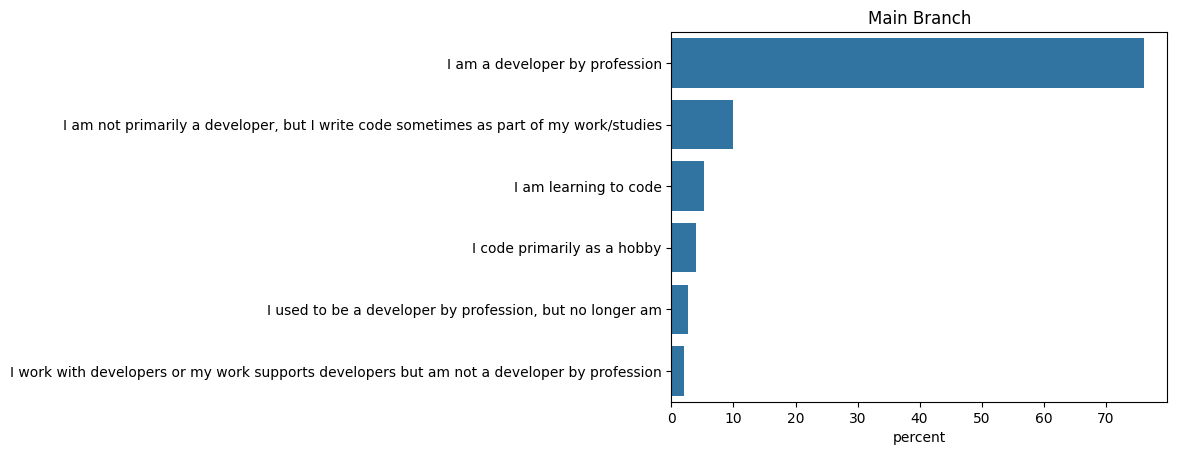

In [12]:
plot_single_selection(df, "MainBranch")

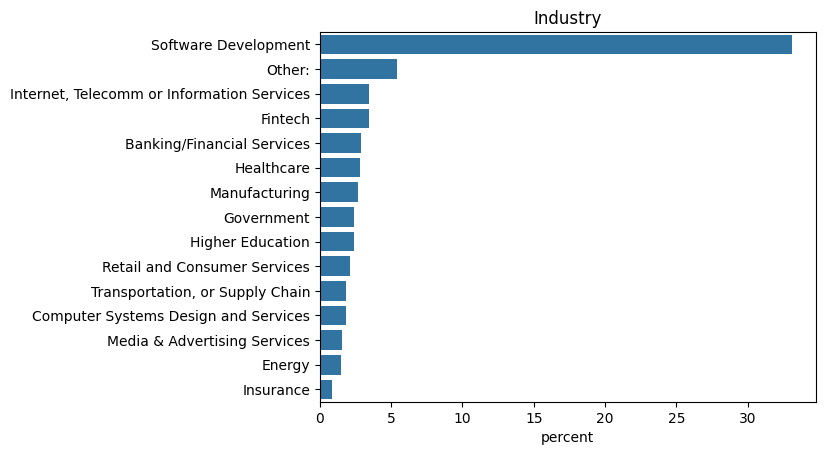

In [13]:
plot_single_selection(df, "Industry")

## Learning

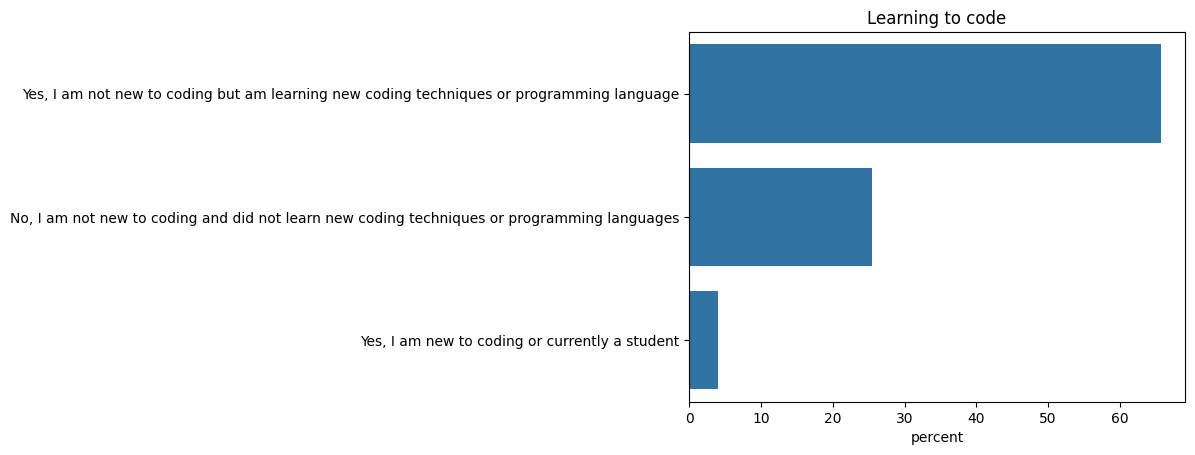

In [14]:
plot_single_selection(df, "LearnCodeChoose", "Learning to code")

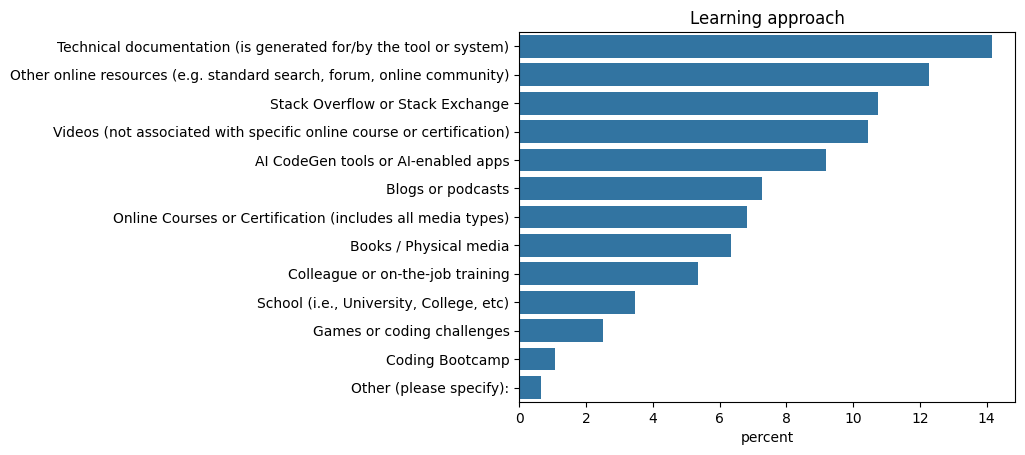

In [15]:
plot_multiple_selection(df, "LearnCode", "Learning approach")

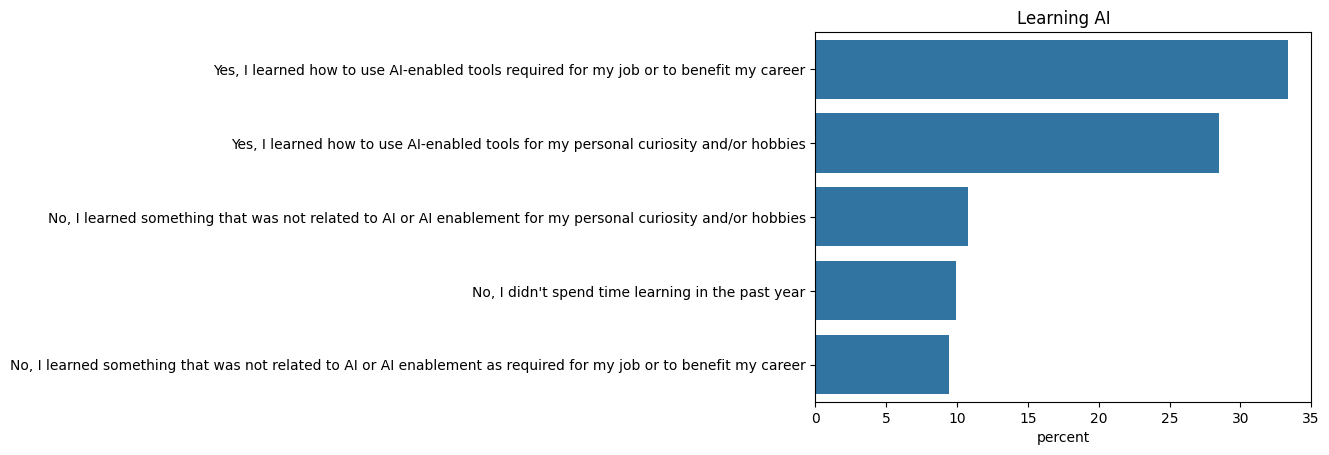

In [16]:
plot_single_selection(df, "LearnCodeAI", "Learning AI")

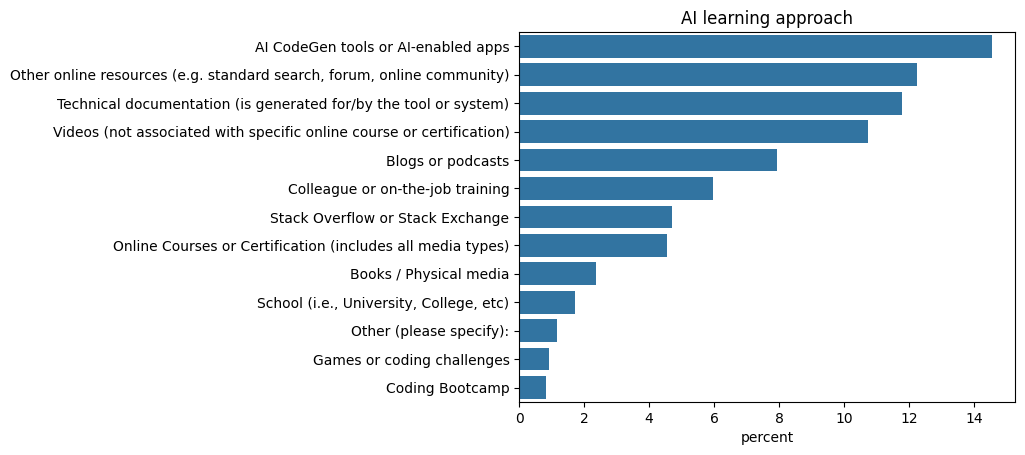

In [17]:
plot_multiple_selection(df, "AILearnHow", "AI learning approach")

## Tech Endorsement

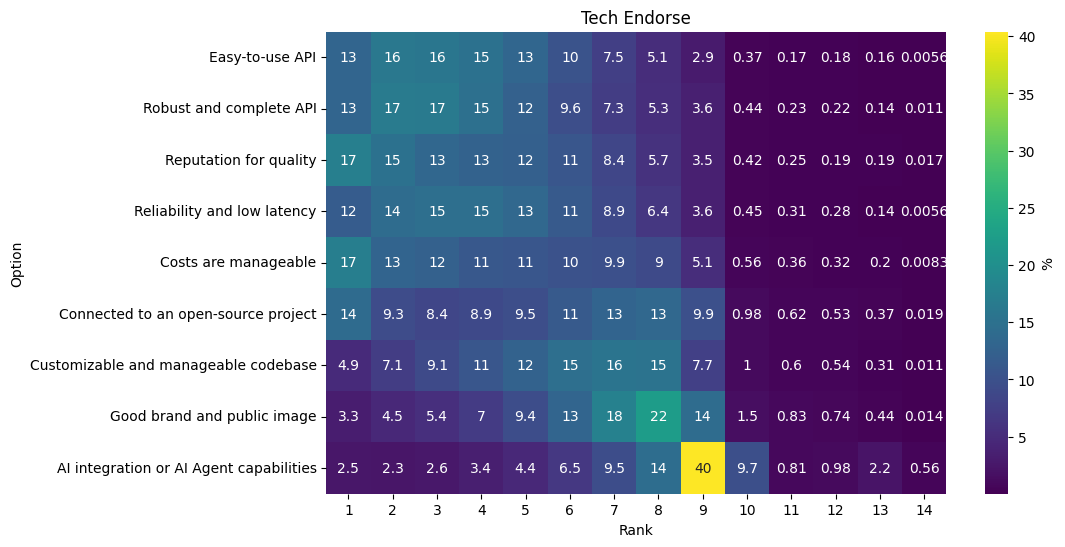

In [18]:
plot_ranking(df, "TechEndorse")

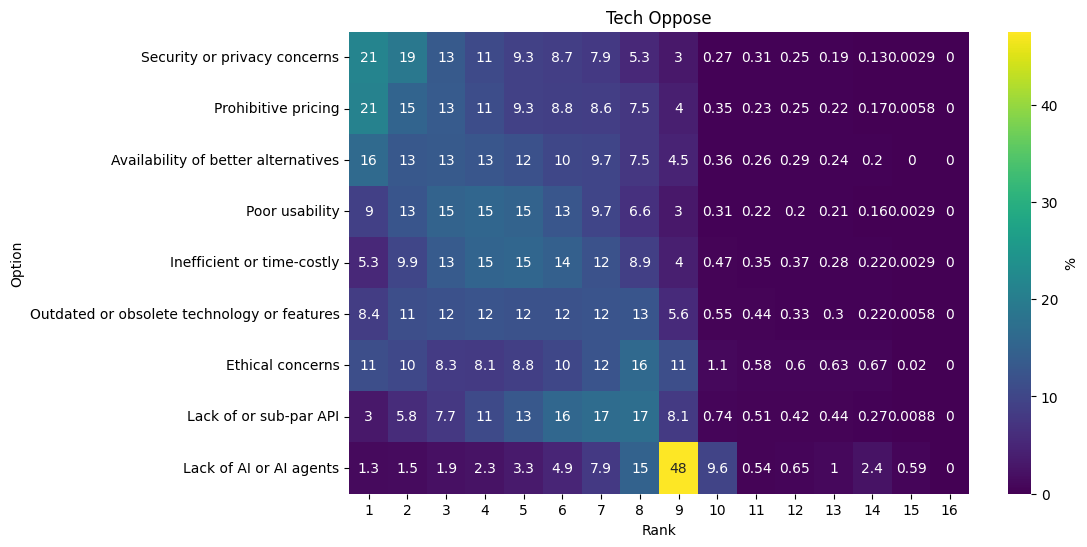

In [19]:
plot_ranking(df, "TechOppose")

## Job satisfaction

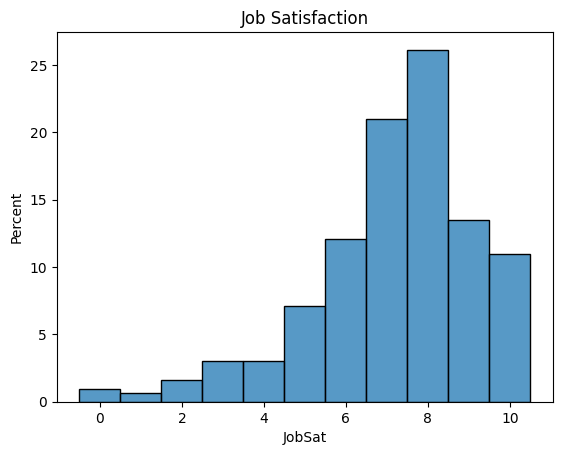

In [20]:
plot_numerical_field(df, "JobSat", "Job Satisfaction", bins=np.linspace(-0.5, 10.5, 12))

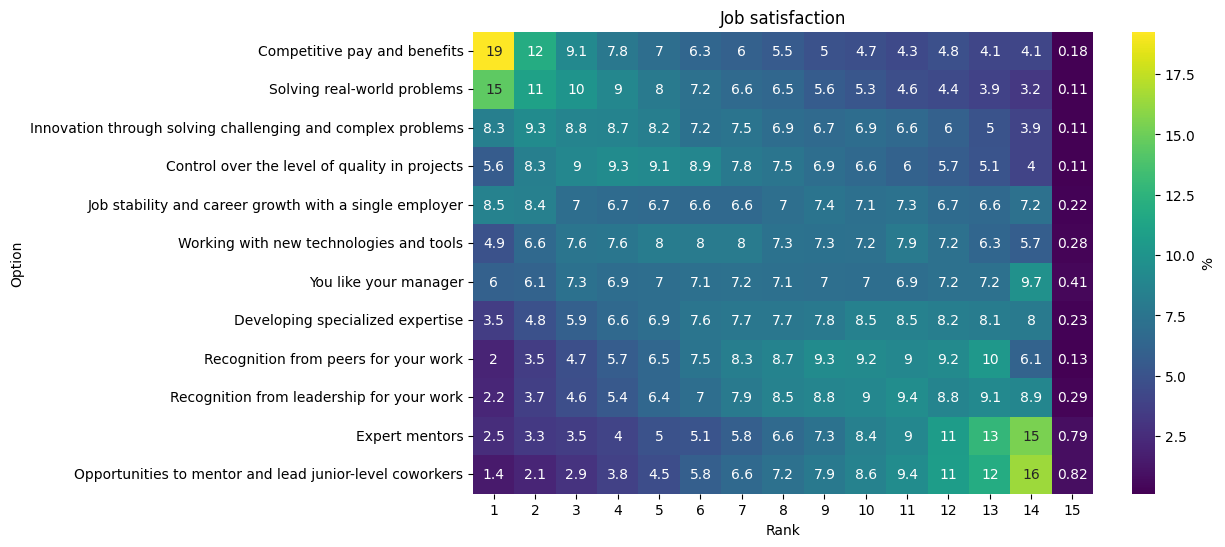

In [21]:
plot_ranking(df, "JobSatPoints", "Job satisfaction")

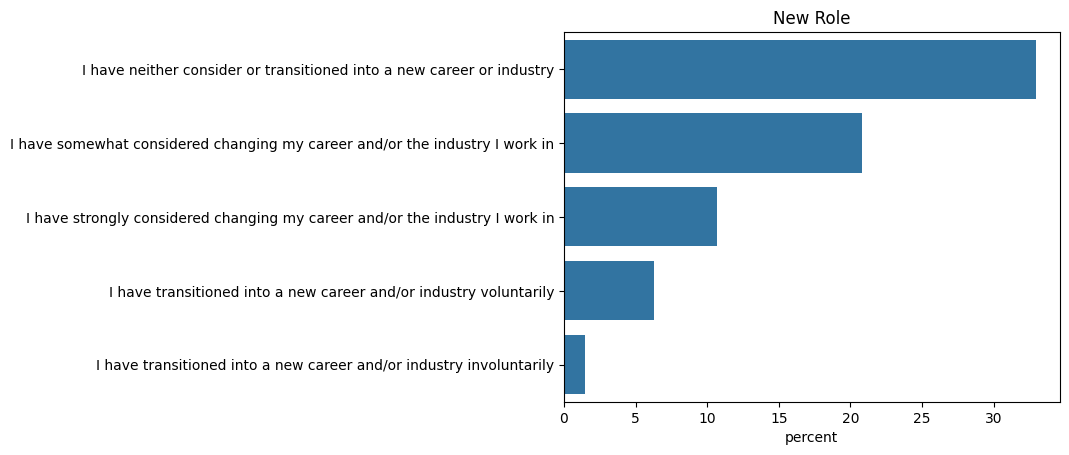

In [22]:
plot_single_selection(df, "NewRole")

## Languages

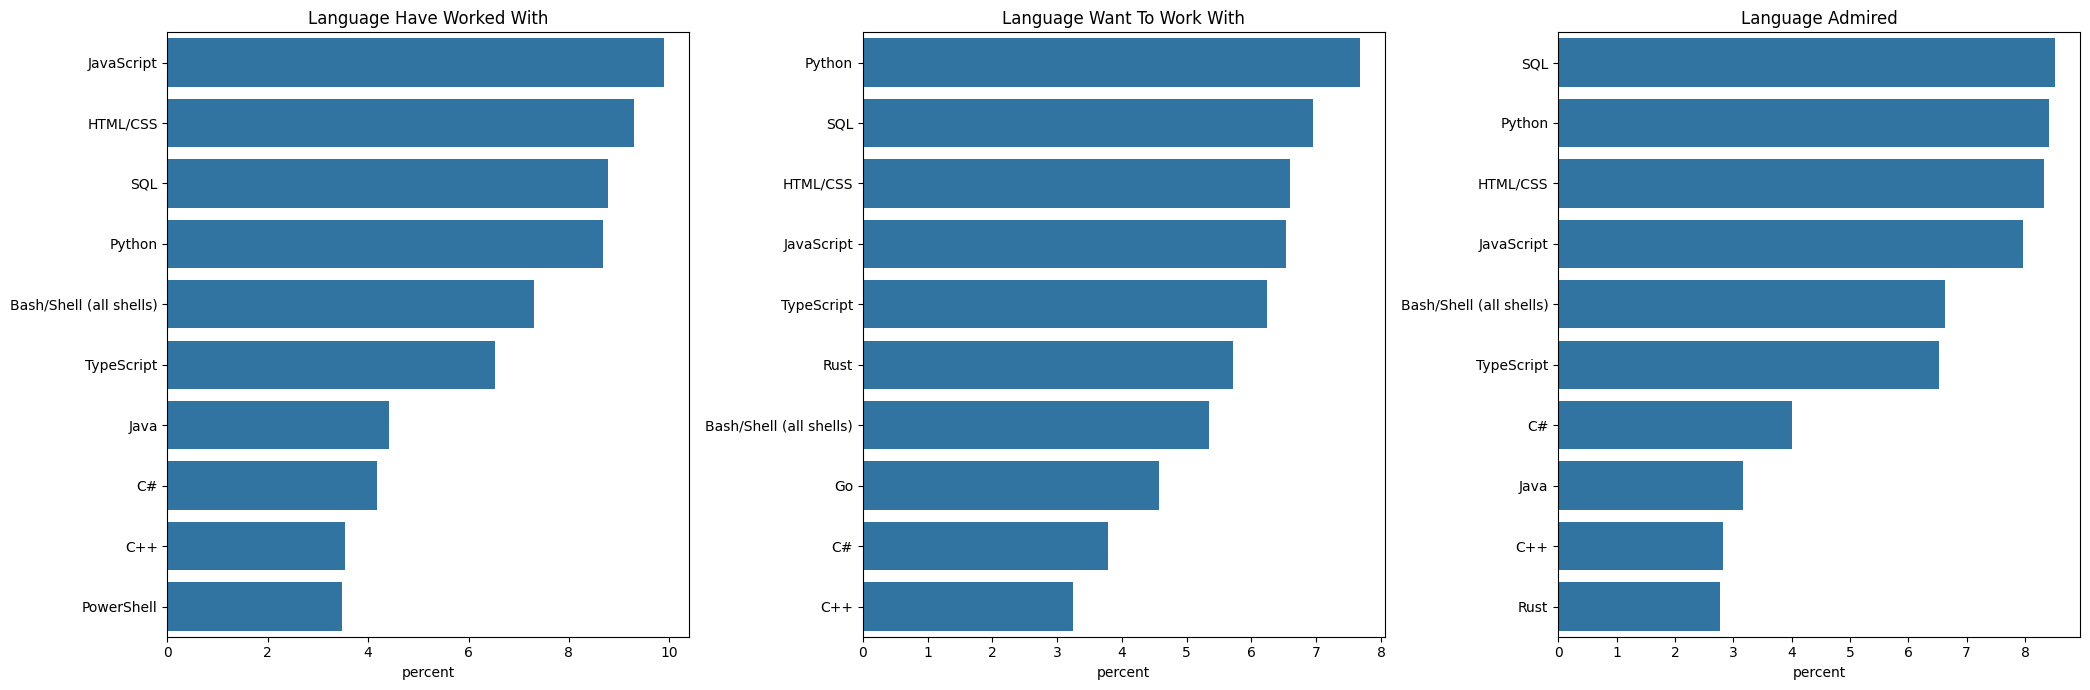

In [23]:
plot_multiple_selection_combi(df, "Language", max_items=10)

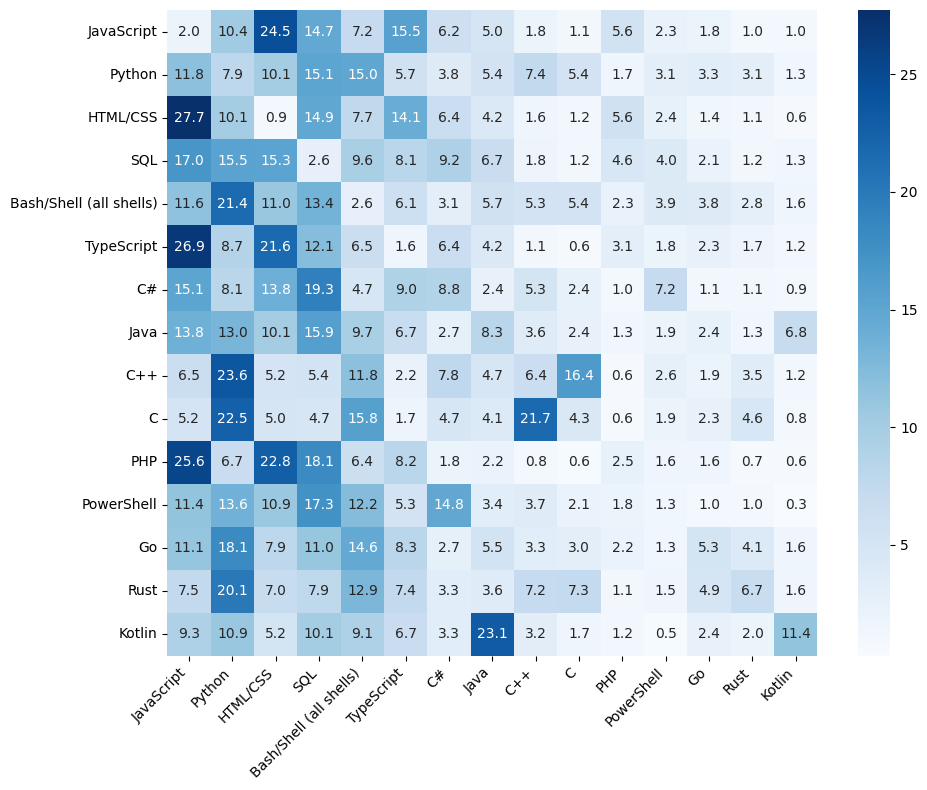

In [24]:
plot_co_occurance(df, "LanguageHaveWorkedWith")

C:\Users\jflorez\AppData\Local\Temp\ipykernel_19556\104864367.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Have"] = df2[column_have].str.split(";")
C:\Users\jflorez\AppData\Local\Temp\ipykernel_19556\104864367.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Want"] = df2[column_want].str.split(";")


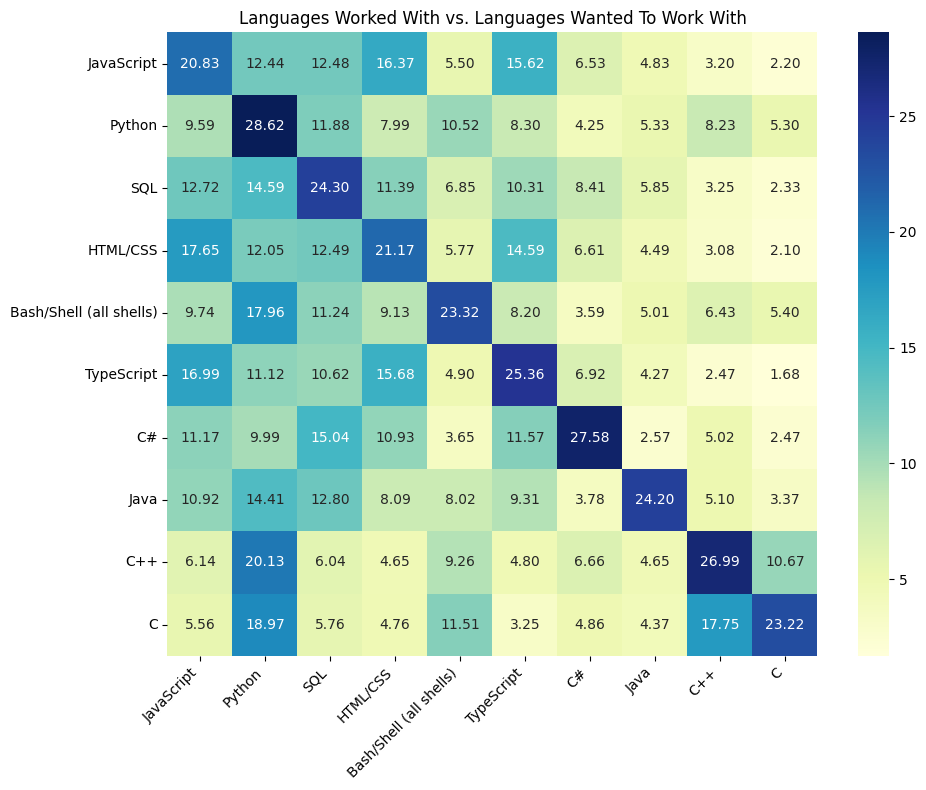

In [25]:
plot_have_and_want2(df, "LanguageHaveWorkedWith", "LanguageWantToWorkWith", n_top=10, max_responses=5)

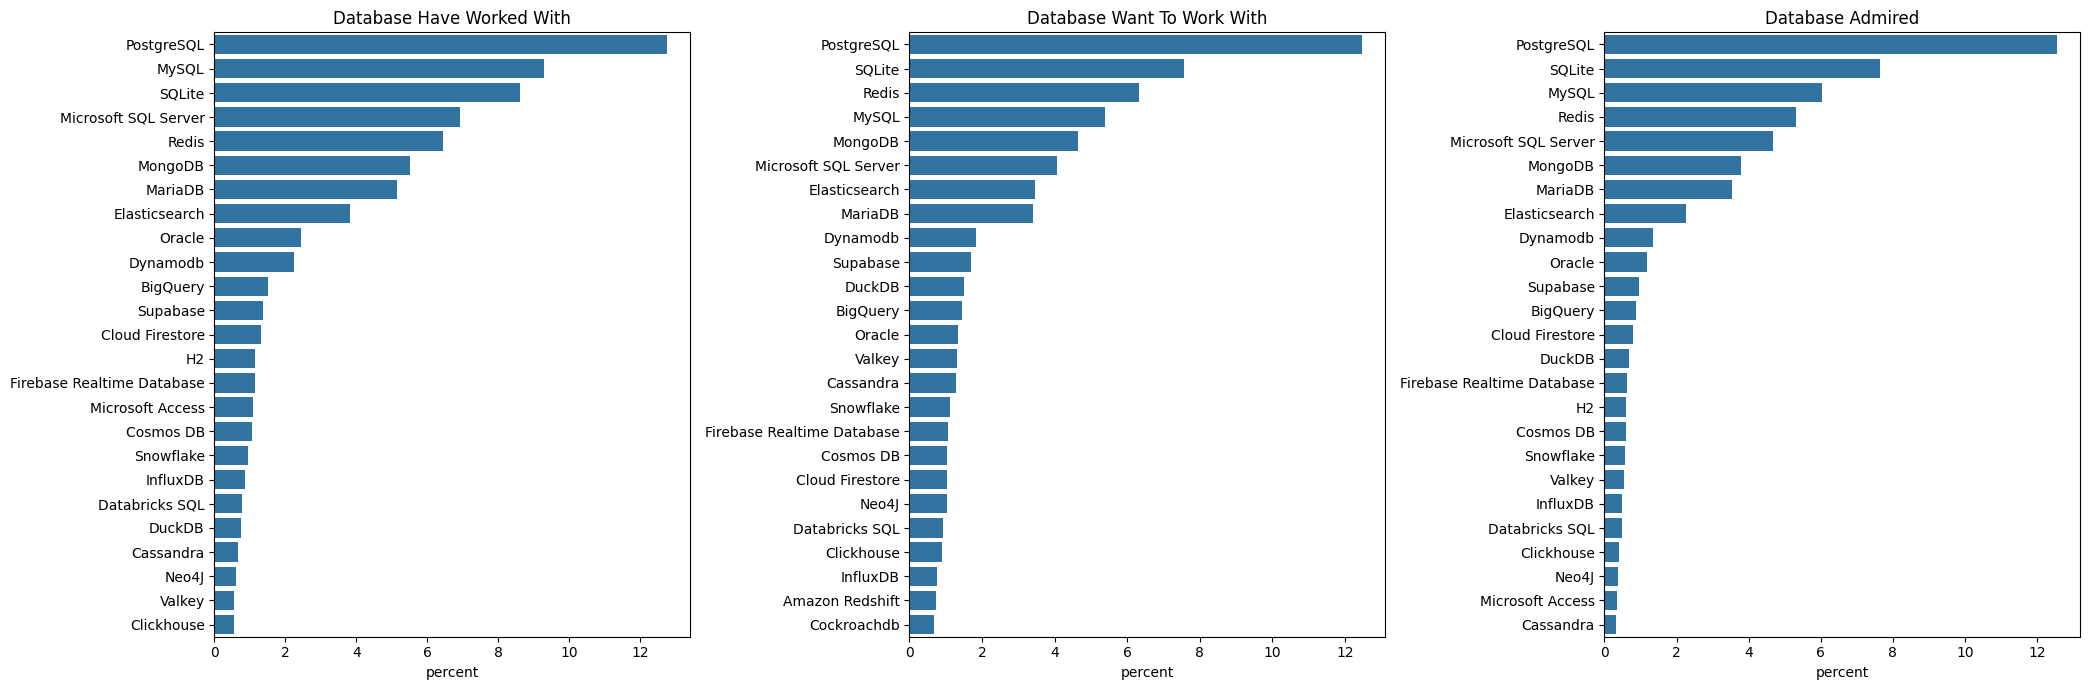

In [26]:
plot_multiple_selection_combi(df, "Database", max_items=25)

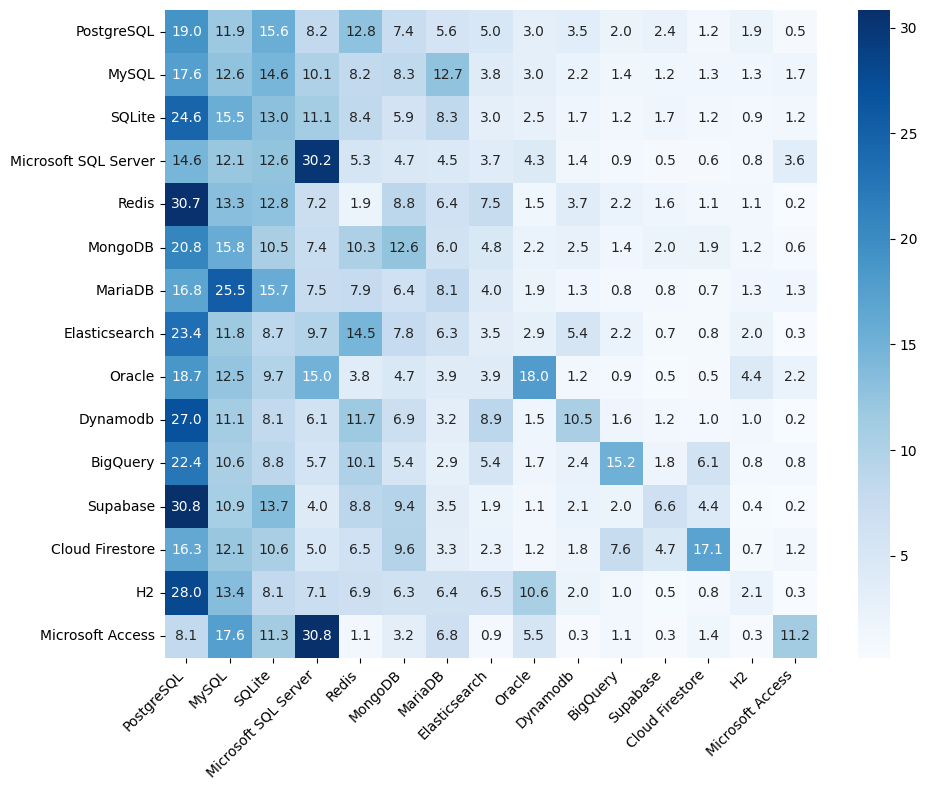

In [27]:
plot_co_occurance(df, "DatabaseHaveWorkedWith")

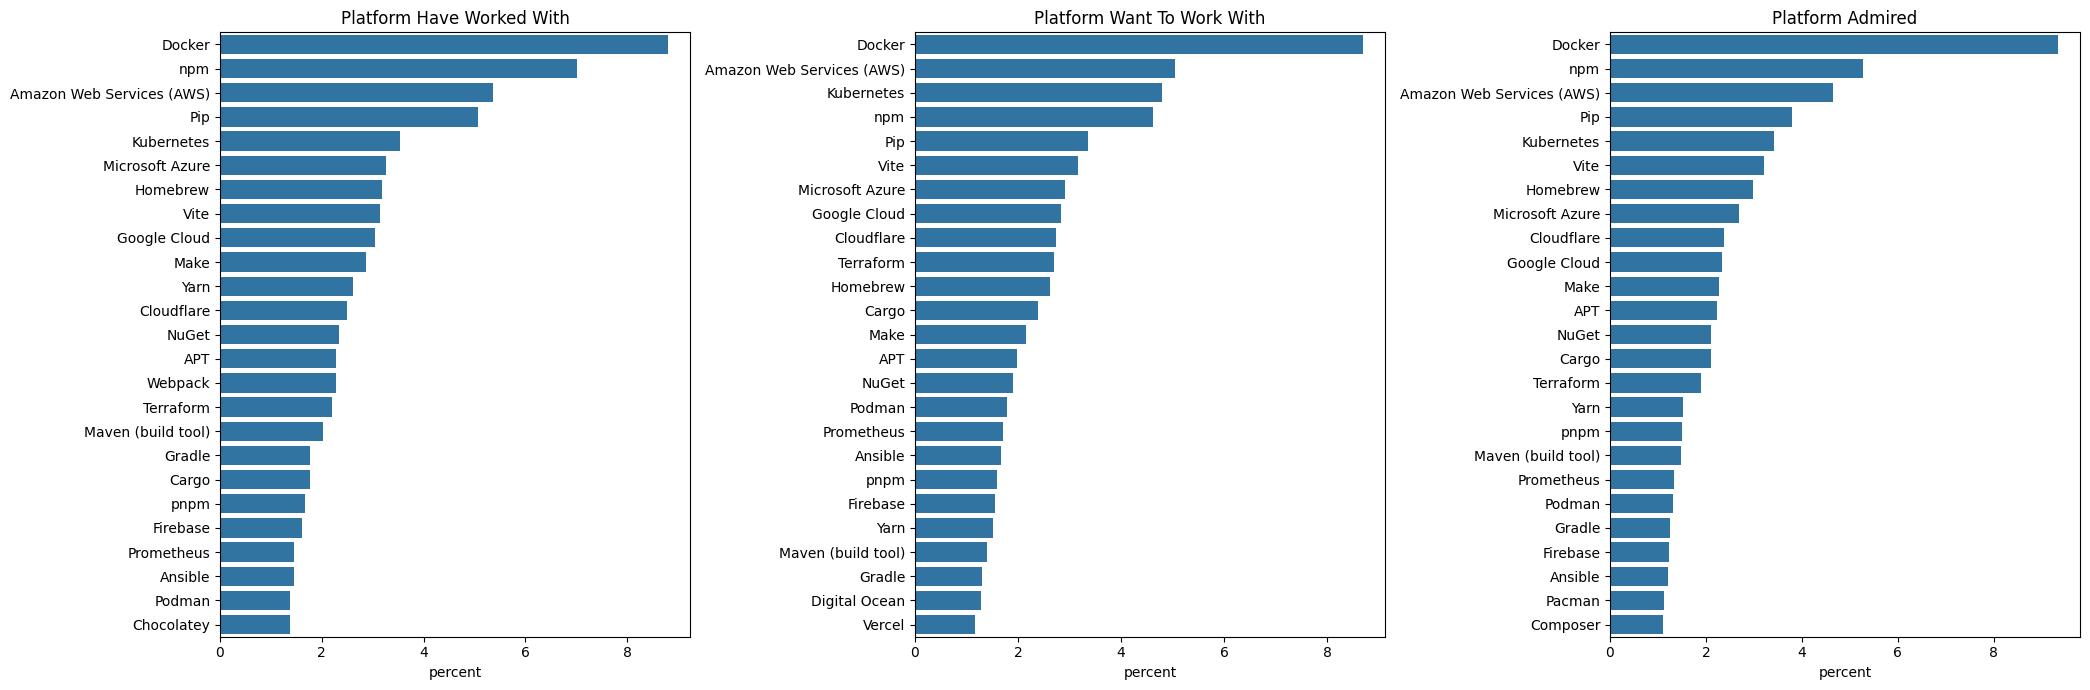

In [28]:
plot_multiple_selection_combi(df, "Platform", max_items=25)

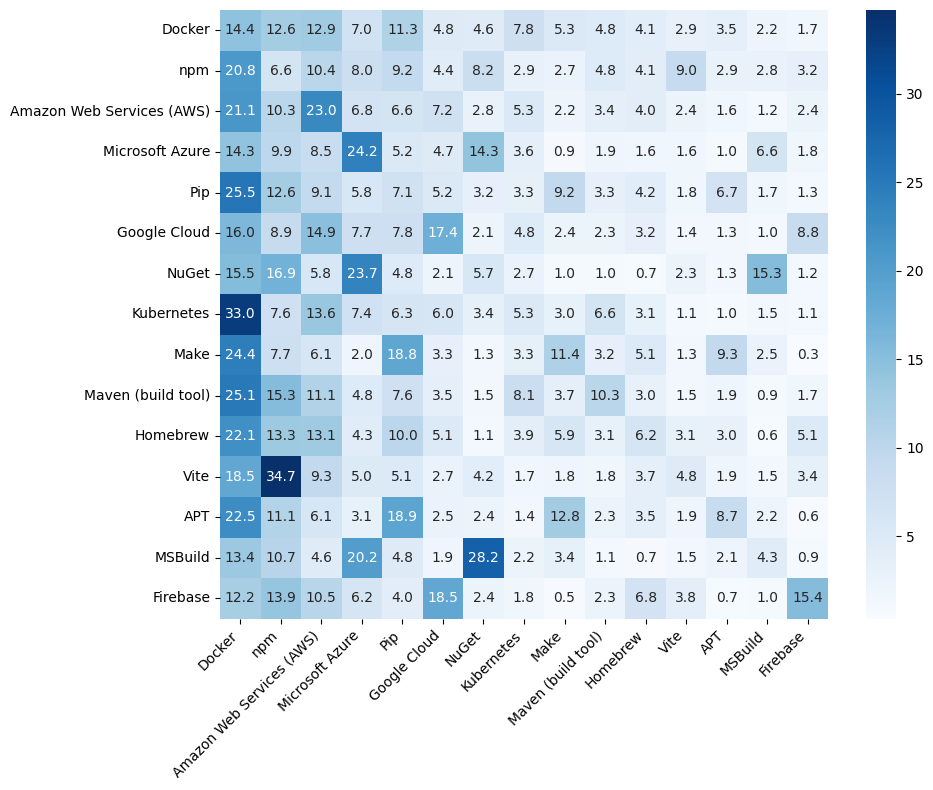

In [29]:
plot_co_occurance(df, "PlatformHaveWorkedWith")

C:\Users\jflorez\AppData\Local\Temp\ipykernel_19556\104864367.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Have"] = df2[column_have].str.split(";")
C:\Users\jflorez\AppData\Local\Temp\ipykernel_19556\104864367.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Want"] = df2[column_want].str.split(";")


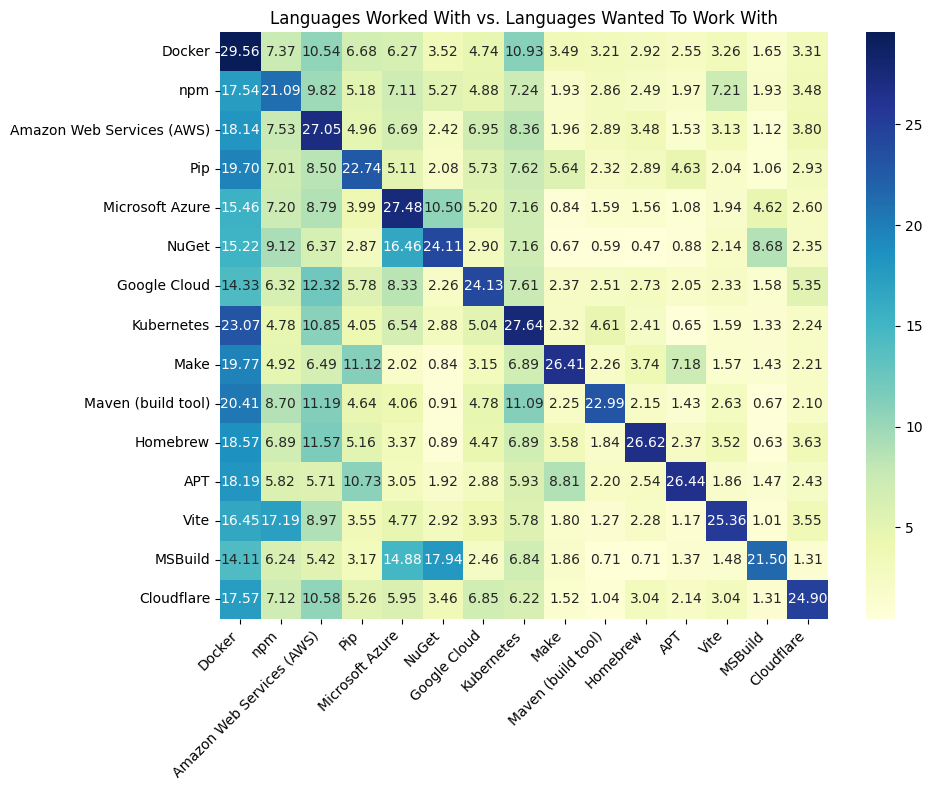

In [30]:
plot_have_and_want2(df, "PlatformHaveWorkedWith", "PlatformWantToWorkWith", n_top=15, max_responses=5)

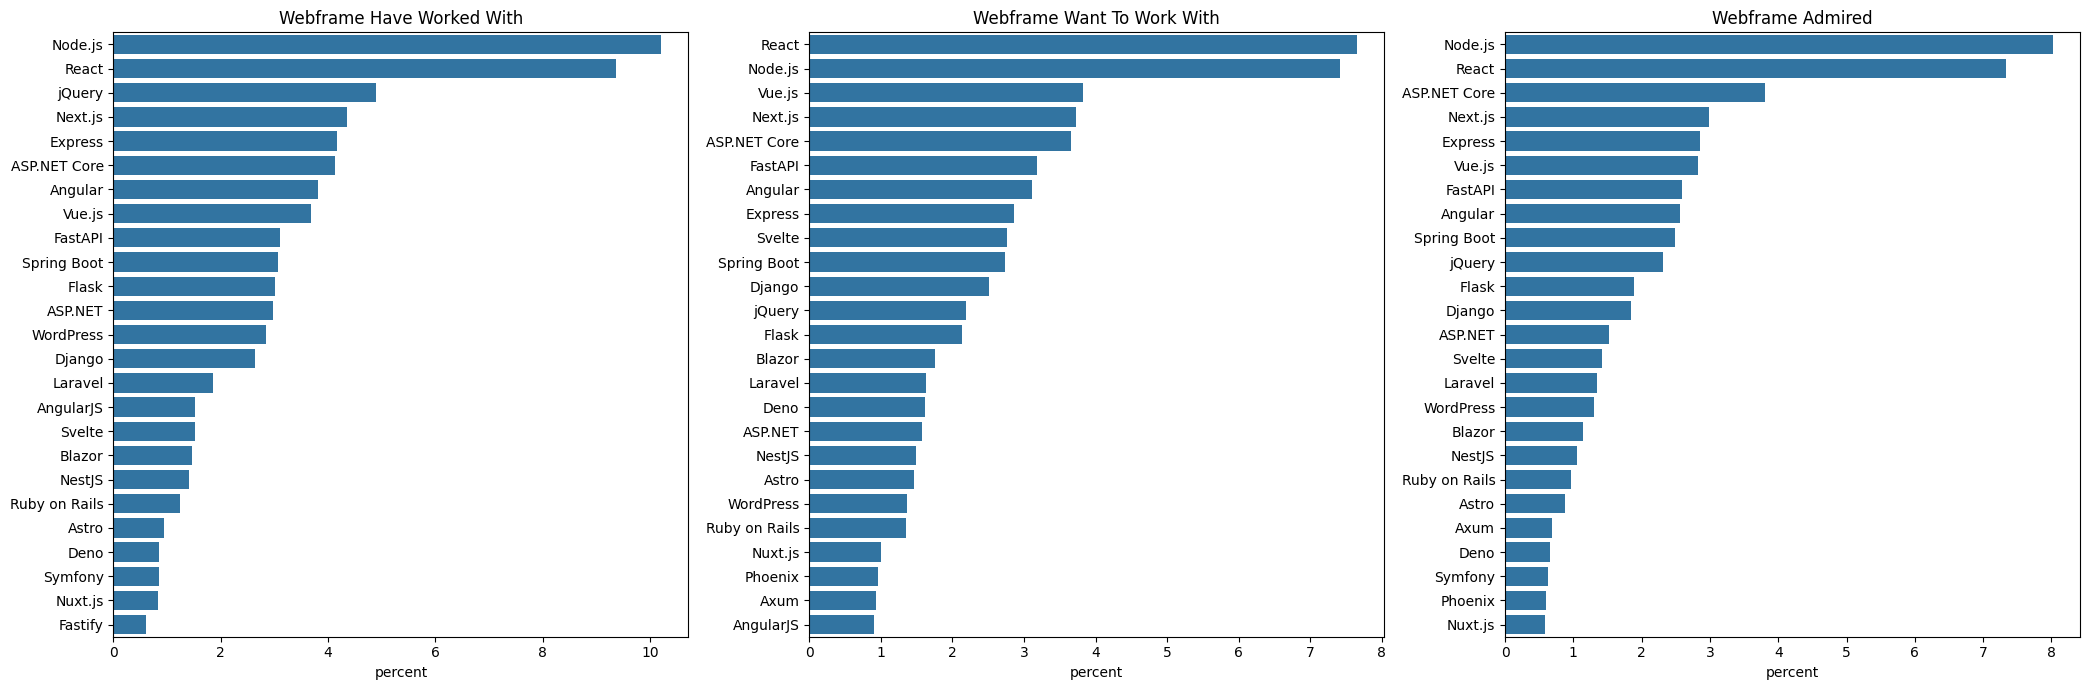

In [31]:
plot_multiple_selection_combi(df, "Webframe", max_items=25)

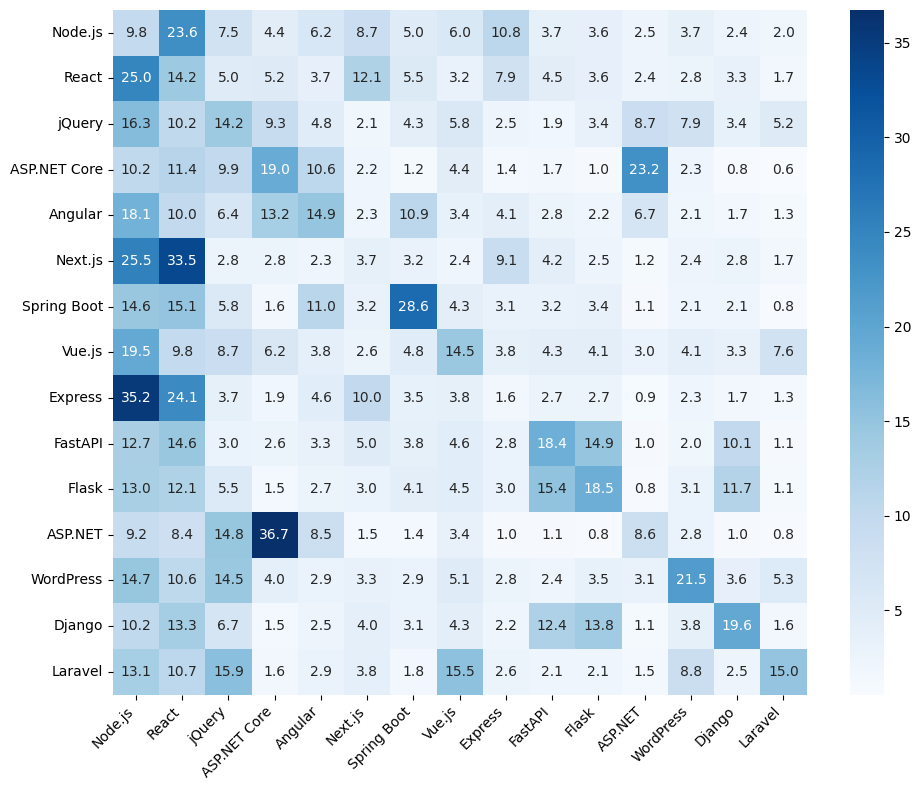

In [32]:
plot_co_occurance(df, "WebframeHaveWorkedWith")

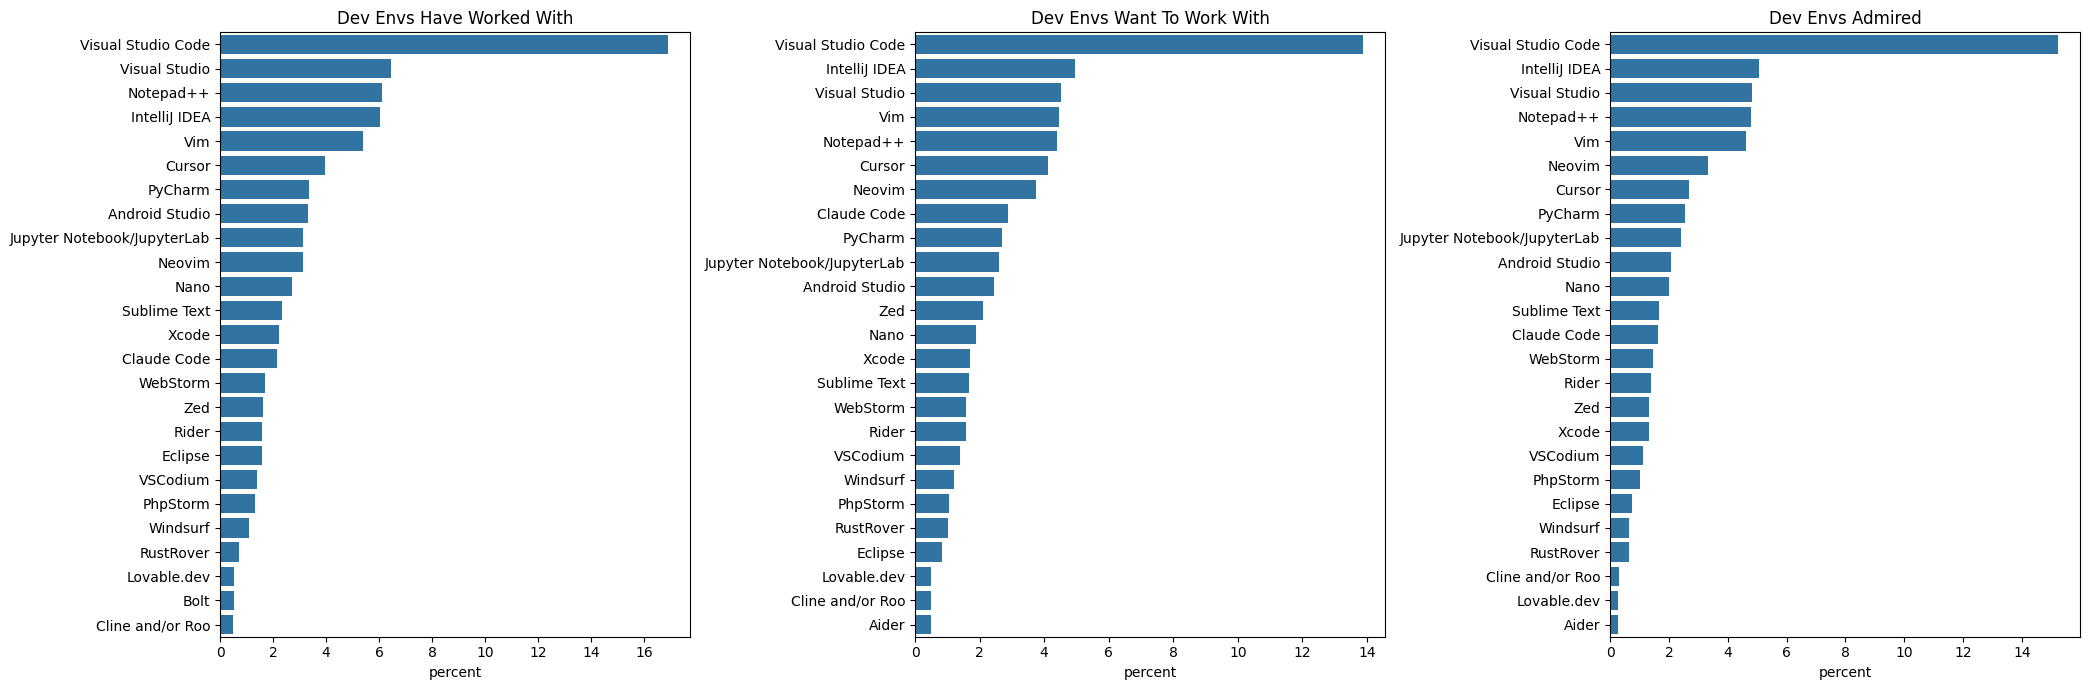

In [33]:
plot_multiple_selection_combi(df, "DevEnvs", max_items=25)

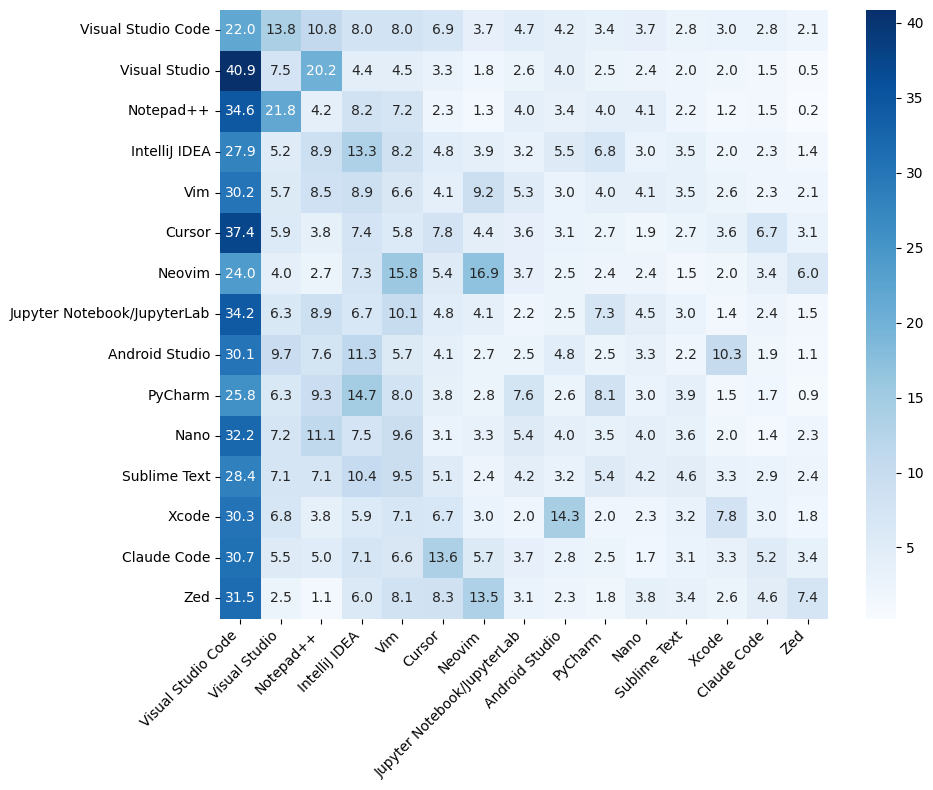

In [34]:
plot_co_occurance(df, "DevEnvsHaveWorkedWith")

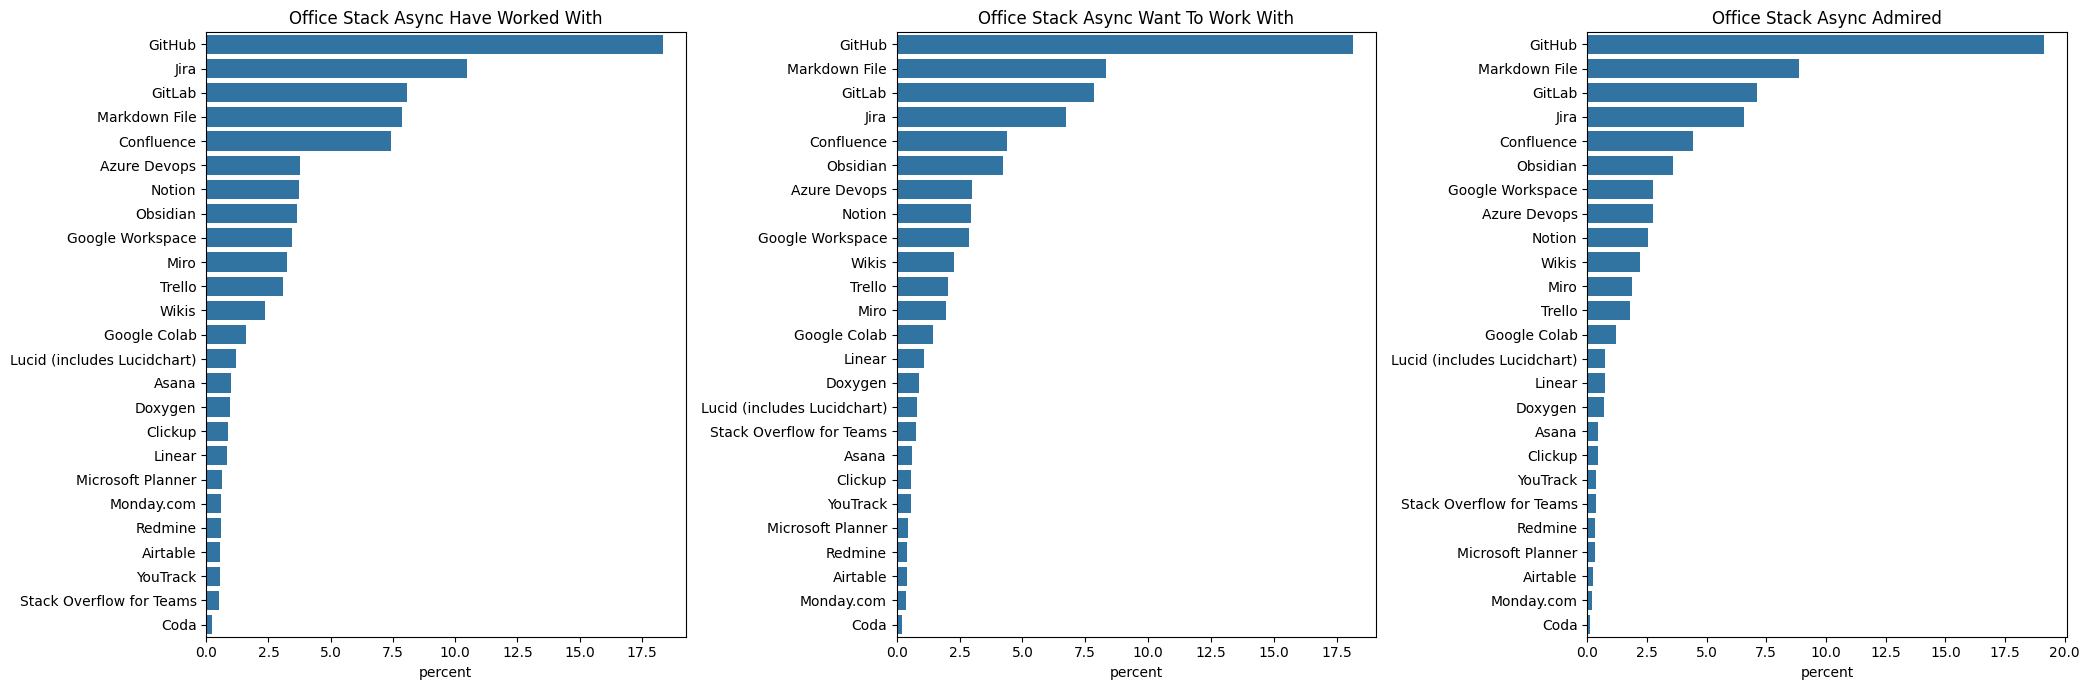

In [35]:
plot_multiple_selection_combi(df, "OfficeStackAsync", max_items=25)

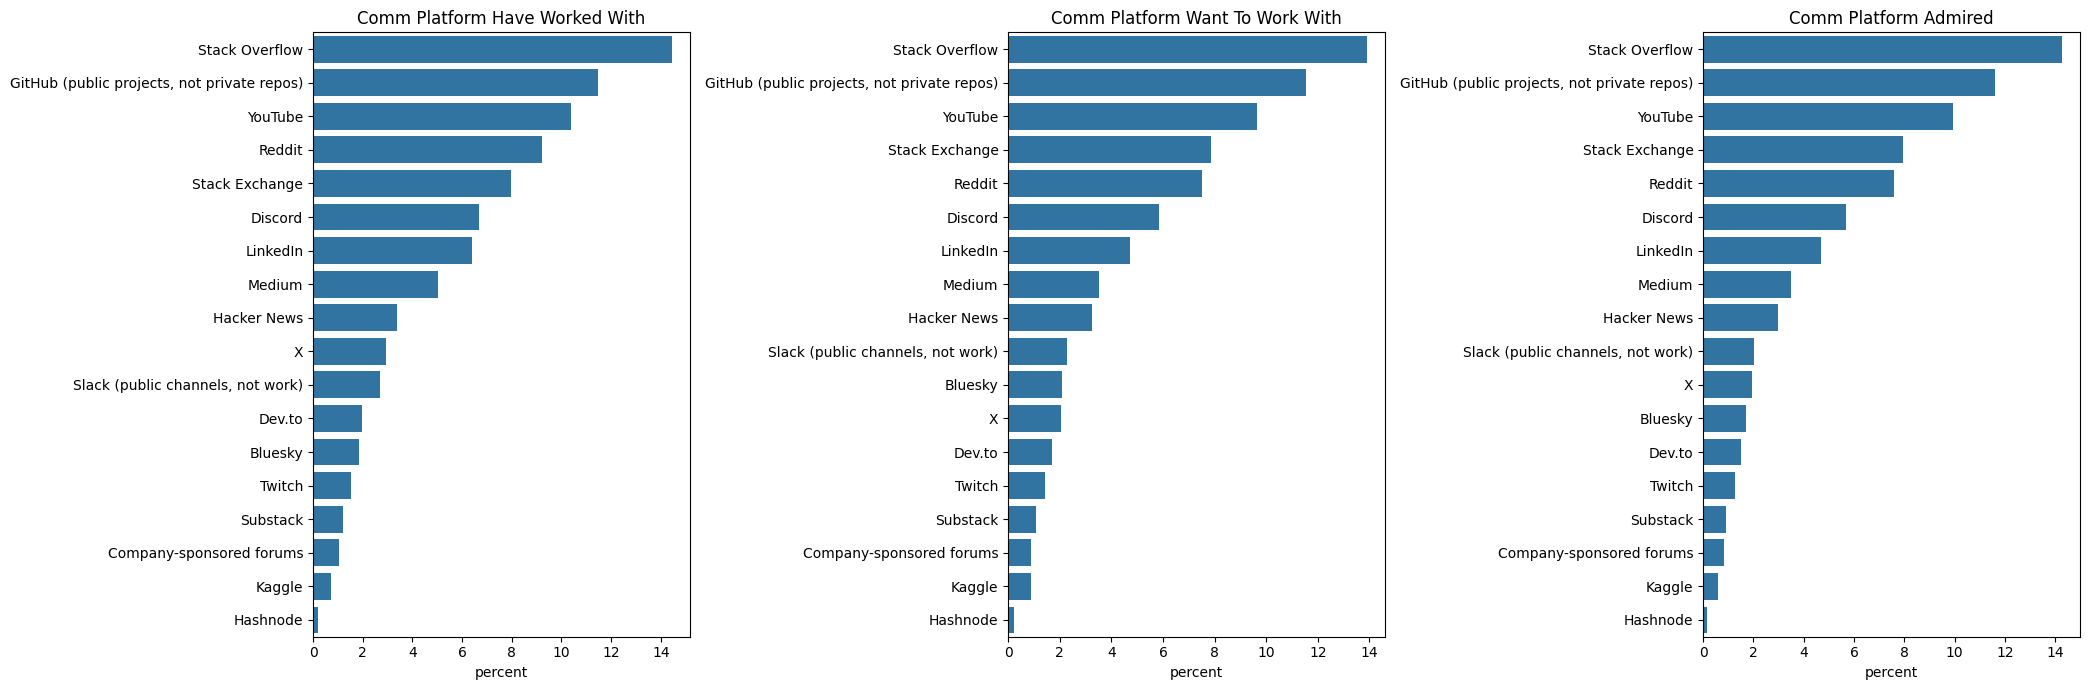

In [36]:
plot_multiple_selection_combi(df, "CommPlatform", max_items=25)

## AI

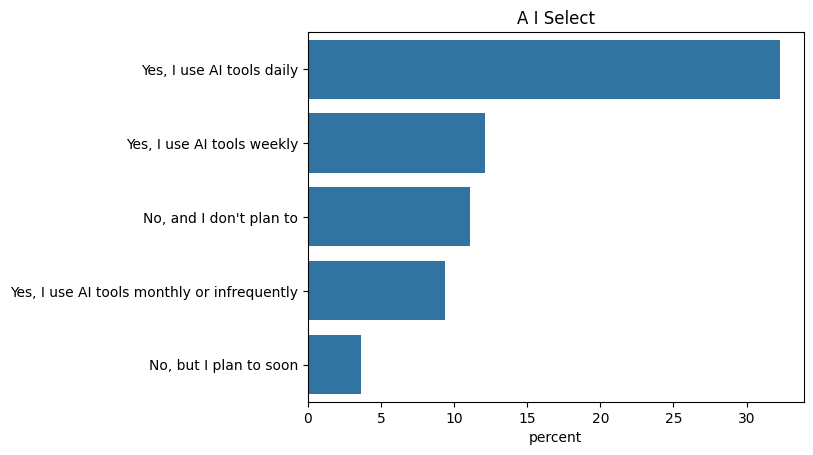

In [37]:
plot_single_selection(df, "AISelect")

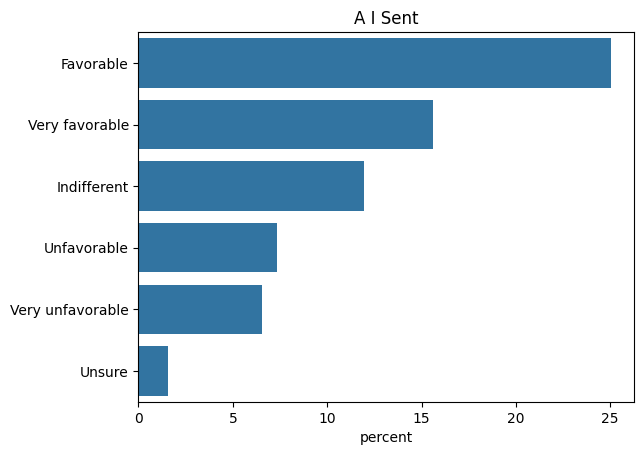

In [38]:
plot_single_selection(df, "AISent")

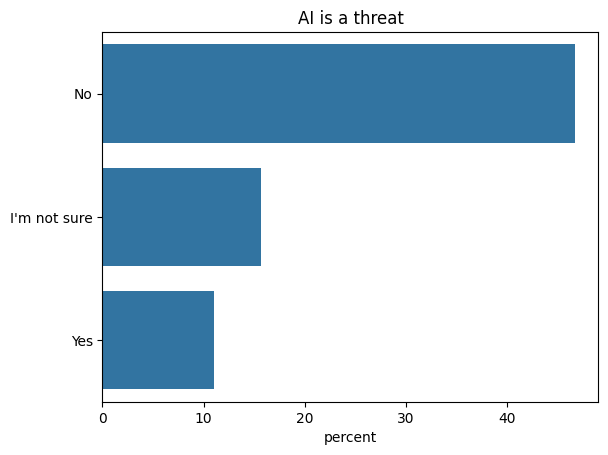

In [39]:
plot_single_selection(df, "AIThreat", "AI is a threat")

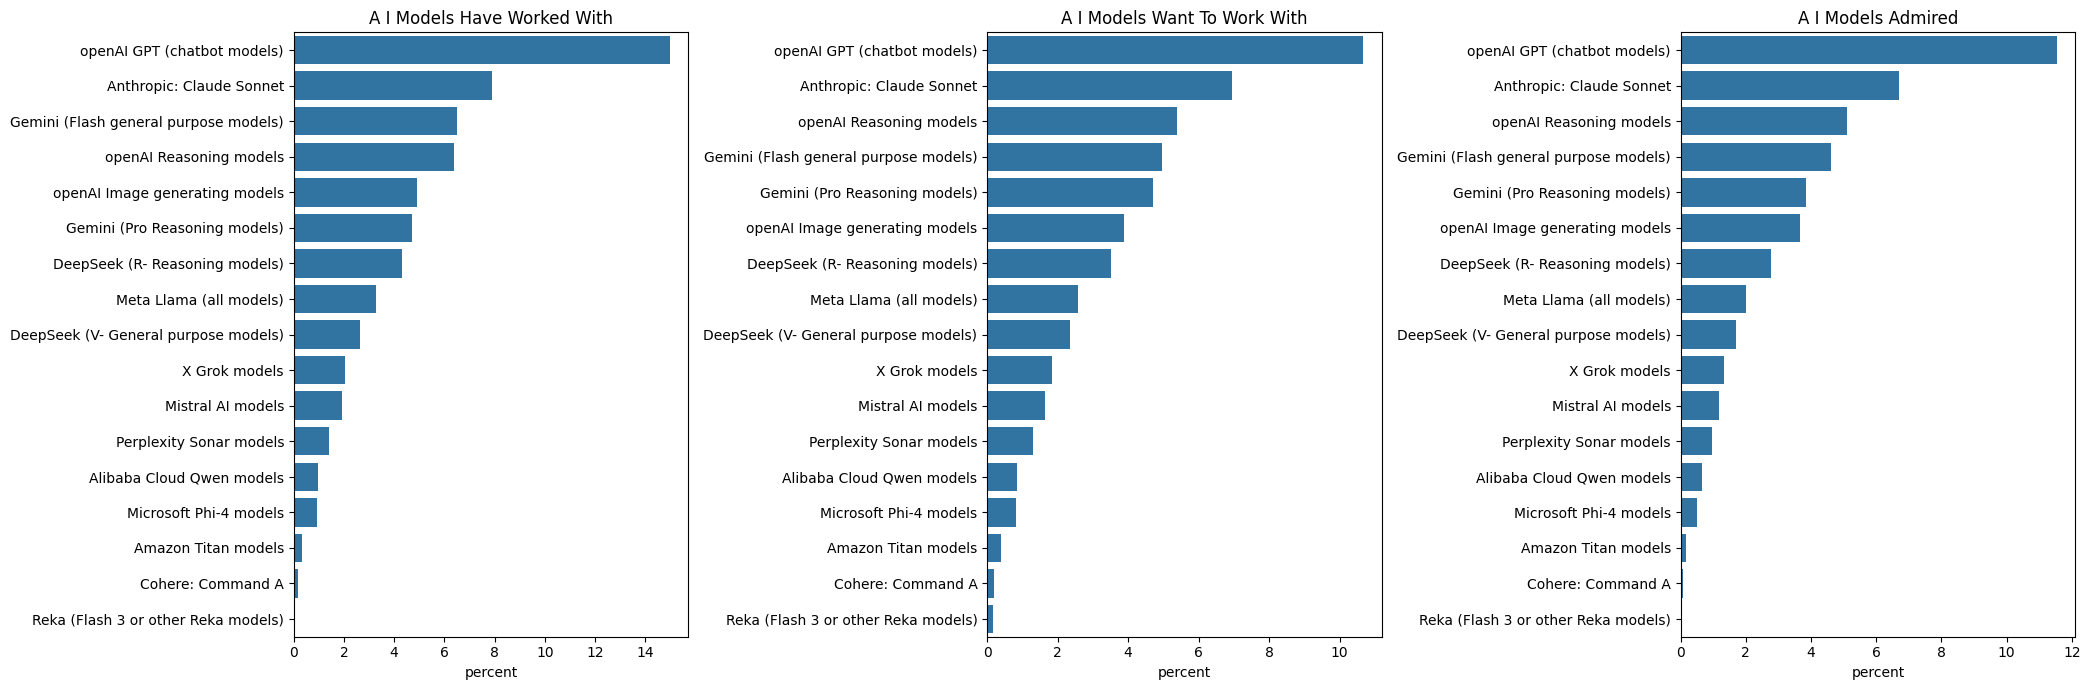

In [40]:
plot_multiple_selection_combi(df, "AIModels", max_items=25)

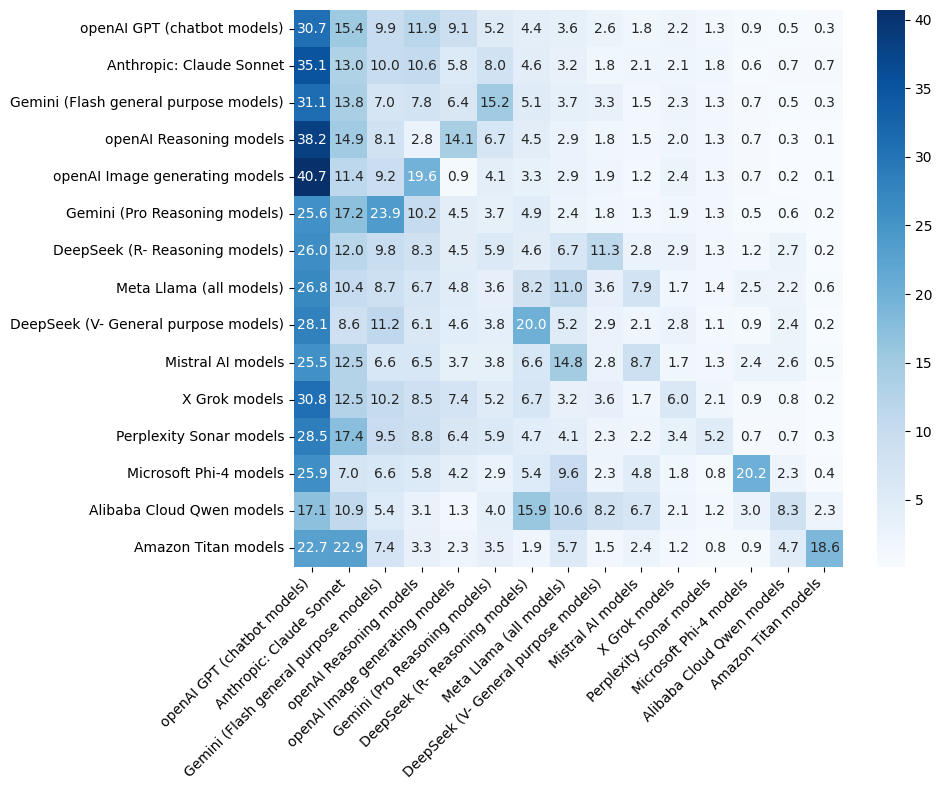

In [41]:
plot_co_occurance(df, "AIModelsHaveWorkedWith")

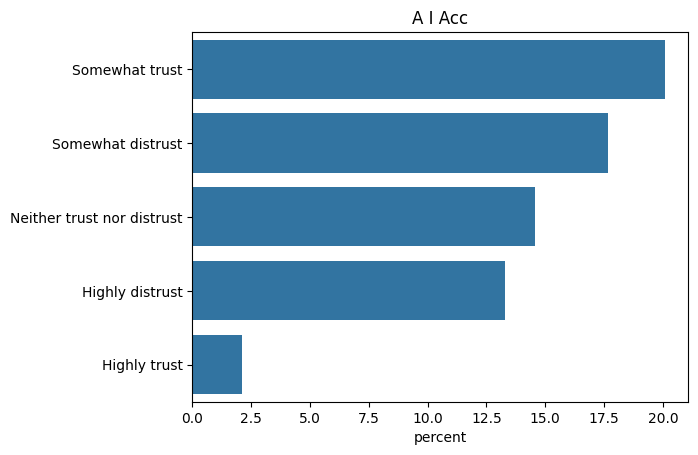

In [42]:
plot_single_selection(df, "AIAcc")

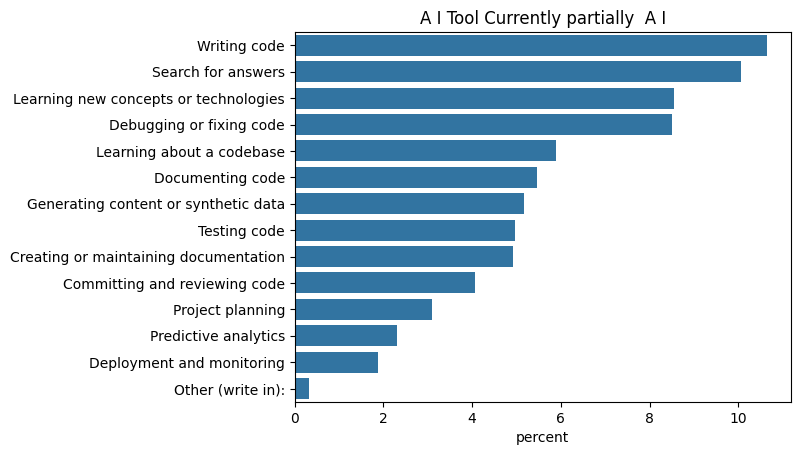

In [43]:
plot_multiple_selection(df, "AIToolCurrently partially AI")

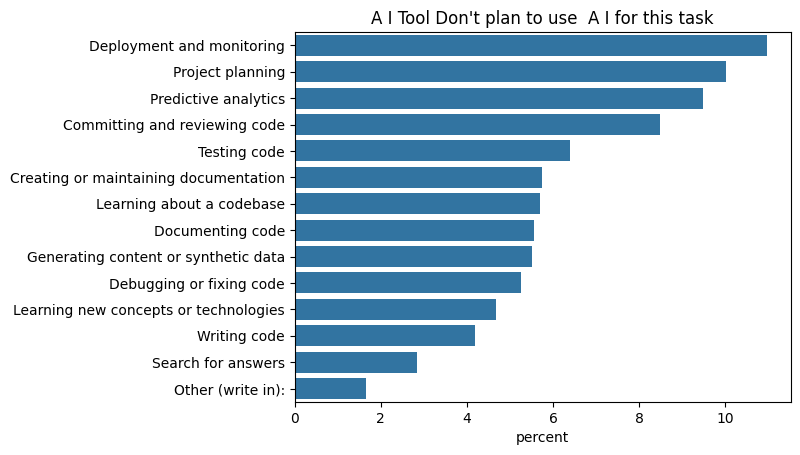

In [44]:
plot_multiple_selection(df, "AIToolDon't plan to use AI for this task")

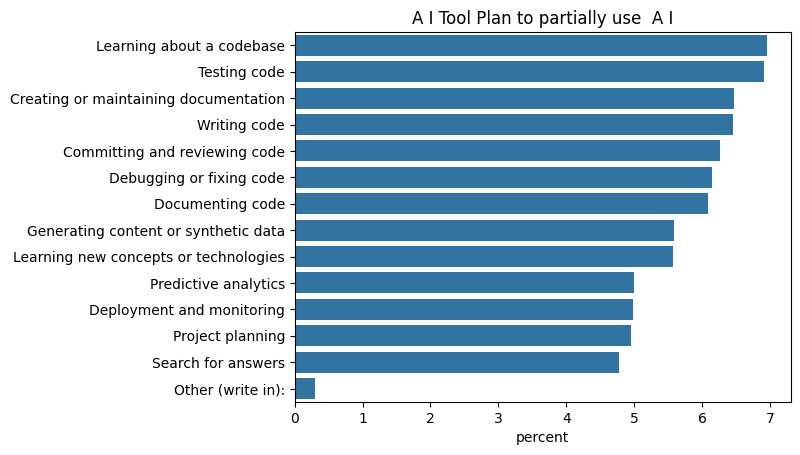

In [45]:
plot_multiple_selection(df, "AIToolPlan to partially use AI")

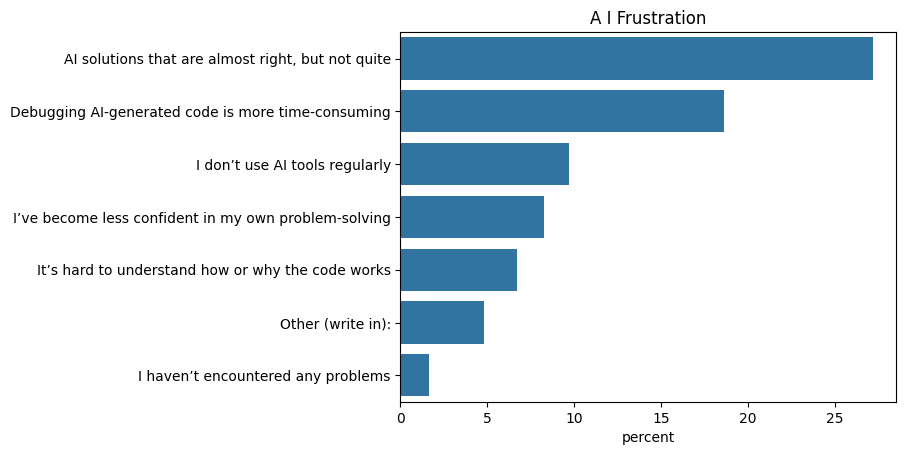

In [46]:
plot_multiple_selection(df, "AIFrustration")

C:\Users\jflorez\AppData\Local\Temp\ipykernel_19556\383376733.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df["AISent"].isin(["Unsure", "Indiferent"]), "Positive AI Sentiment"] = np.nan


<Axes: xlabel='JobSat', ylabel='Percent'>

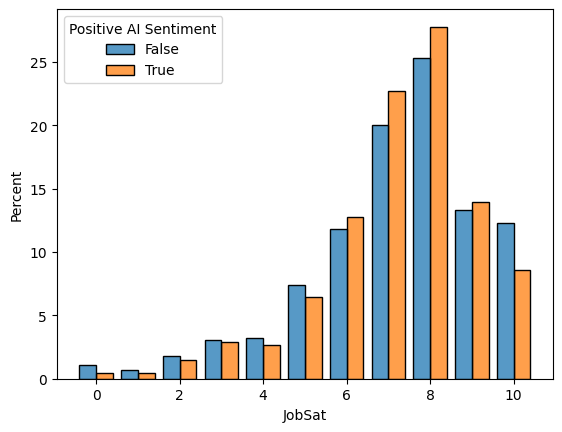

In [47]:
df["Positive AI Sentiment"] = df["AISent"].isin(["Favorable", "Very Favorable"])
df.loc[df["AISent"].isin(["Unsure", "Indiferent"]), "Positive AI Sentiment"] = np.nan

sns.histplot(df, x="JobSat", hue="Positive AI Sentiment", bins=np.arange(-0.5, 11.5), stat="percent", multiple="dodge", shrink=0.8, common_norm=False)

In [48]:
# Function to compute fraction of matches
def compute_fraction_match(row):
    try:
        have = set(str(row['LanguageHaveWorkedWith']).split(';'))
        want = str(row['LanguageWantToWorkWith']).split(';')
        want_clean = [lang for lang in want if lang]
        if not want_clean:
            return None
        match_count = sum(lang in have for lang in want_clean)
        return match_count / len(want_clean)
    except:
        return None

# Apply the function to each row
df['FractionMatch'] = df.apply(compute_fraction_match, axis=1)


<Axes: xlabel='FractionMatch', ylabel='Percent'>

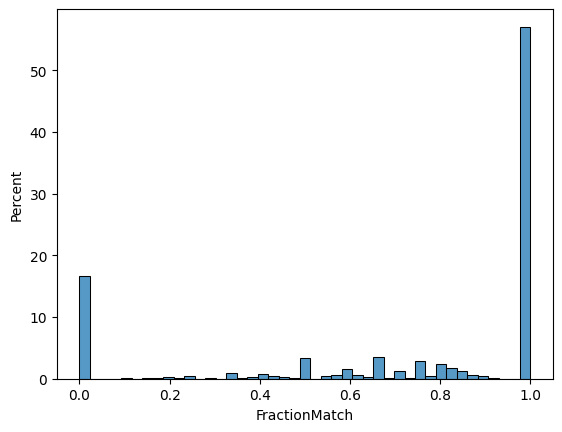

In [49]:
sns.histplot(df, x='FractionMatch', stat="percent")

In [50]:
# Categorize into LanguageMatch
conditions = [
    (df['FractionMatch'] >= 0) & (df['FractionMatch'] < 0.2),
    (df['FractionMatch'] >= 0.2) & (df['FractionMatch'] < 0.8),
    (df['FractionMatch'] >= 0.8) & (df['FractionMatch'] <= 1.0)
]
choices = ['low', 'medium', 'high']
df['LanguageMatch'] = np.select(conditions, choices, default="None")

<Axes: xlabel='JobSat', ylabel='Percent'>

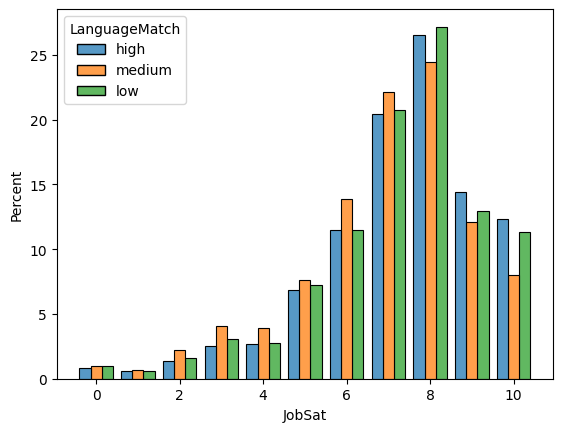

In [51]:
sns.histplot(df, x="JobSat", hue="LanguageMatch", bins=np.arange(-0.5, 11.5), stat="percent", multiple="dodge", shrink=0.8, common_norm=False)